In [ ]:
# default_exp connectomes

# Module connectomes

> Pipeline making use of `postprocessing` nodes to generate a connectivity matrix and distance matrix.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#exporti
import os
import bids
bids.config.set_option('extension_initial_dot', True)

from nipype.pipeline import Node, Workflow

import pipetography.nodes as nodes
import pipetography.core as ppt

/opt/miniconda3/envs/tracts/lib/python3.9/site-packages/bids/config.py:39: FutureWarning: Setting 'extension_initial_dot' will be removed in pybids 0.16.
  warnings.warn("Setting 'extension_initial_dot' will be removed in pybids 0.16.",
/opt/miniconda3/envs/tracts/lib/python3.9/site-packages/bids/config.py:39: FutureWarning: Setting 'extension_initial_dot' will be removed in pybids 0.16.
  warnings.warn("Setting 'extension_initial_dot' will be removed in pybids 0.16.",
/opt/miniconda3/envs/tracts/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [ ]:
#export

class connectome:
    """
    Create a pipeline that produces connectomes based on input atlases and streamlines, the pipeline will create sub-graphs based on inputs BIDS directory subject & session combinations.
    
    Inputs:
         - BIDS_dir (str): base BIDS directory path
         - atlas_list (List of strings): names of atlases: aal, brainnectome, desikan-killiany, default is set to brainnectome for now.
         - FA (bool): Default = True; if True, additionally creates an FA weighted connectome.
         - SIFT_mask (bool): Uses 5ttgen tissue segmentation during SIFT2. Defaults to False. If in pipeline `gmwmi = False`, this should also be false.
         - debug (bool): Default = False; if True, saves node outputs and log files.
    """
    
    def __init__(self, BIDS_dir, atlas_list, FA=True, SIFT_mask=False, skip_tuples=[()], debug=False):
        """
        Initialize workflow nodes
        """
        self.bids_dir = BIDS_dir
        self.atlas_list = atlas_list
        self.sub_list, self.ses_list, self.layout = ppt.get_subs(BIDS_dir)
        self.FA = FA,
        self.SIFT_mask = SIFT_mask
        self.skip_combos = skip_tuples
        self.debug_mode = debug
        self.subject_template = {
            'tck': os.path.join(self.bids_dir, 'derivatives', 'streamlines','sub-{subject_id}', 'ses-{session_id}', 'sub-{subject_id}_ses-{session_id}_gmwmi2wm.tck'),
            'brain': os.path.join(self.bids_dir, 'derivatives', 'pipetography', 'sub-{subject_id}', 'ses-{session_id}', 'preprocessed', 'dwi_space-acpc_res-1mm_seg-brain.nii.gz'),
            'dwi_mif': os.path.join(self.bids_dir, 'derivatives', 'pipetography', 'sub-{subject_id}', 'ses-{session_id}', 'preprocessed', 'dwi_space-acpc_res-1mm.mif'),
            'T1A': os.path.join(self.bids_dir, 'derivatives', 'pipetography', 'sub-{subject_id}', 'ses-{session_id}', 'preprocessed', 'T1w_space-acpc.nii.gz'),
            'mask': os.path.join(self.bids_dir, 'derivatives', 'pipetography', 'sub-{subject_id}', 'ses-{session_id}', 'preprocessed', 'dwi_space-acpc_res-1mm_seg-brain_mask.nii.gz'),
        }
        
        if self.SIFT_mask:
            self.subject_template['mrtrix5tt'] = os.path.join(self.bids_dir, 'derivatives', 'pipetography', 'sub-{subject_id}', 'ses-{session_id}', 'preprocessed', 'T1w_space-acpc_seg-5tt.mif')
        
    def create_nodes(self):
        """
        Create postprocessing nodes, and make output path substitutions so outputs are BIDS compliant.
        """
        self.PostProcNodes = nodes.PostProcNodes(
            BIDS_dir=self.bids_dir,
            subj_template = self.subject_template,
            sub_list = self.sub_list,
            ses_list = self.ses_list,
            skip_tuples = self.skip_combos)
        self.PostProcNodes.linear_reg.iterables = [('moving_image', self.atlas_list)]
        self.workflow = None
        
        
    def connect_nodes(self, wf_name="connectomes"):
        """
        Connect postprocessing nodes into workflow
        """
        self.workflow = Workflow(name=wf_name, base_dir=os.path.join(self.bids_dir, 'derivatives'))
        self.workflow.connect(
            [
                (self.PostProcNodes.subject_source, self.PostProcNodes.select_files, [('subject_id', 'subject_id'),
                                                                                      ('session_id', 'session_id')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.linear_reg, [('brain', 'fixed_image')]),
                (self.PostProcNodes.linear_reg, self.PostProcNodes.nonlinear_reg, [('warped_image', 'moving_image')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.nonlinear_reg, [('brain', 'fixed_image')]),
                (self.PostProcNodes.nonlinear_reg, self.PostProcNodes.connectome, [('warped_image', 'in_parc')]),
                (self.PostProcNodes.nonlinear_reg, self.PostProcNodes.distance, [('warped_image', 'in_parc')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.response, [('dwi_mif', 'in_file')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.fod, [('dwi_mif', 'in_file')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.fod, [('mask', 'mask_file')]),
                (self.PostProcNodes.response, self.PostProcNodes.fod, [('wm_file', 'wm_txt')]),
                (self.PostProcNodes.response, self.PostProcNodes.fod, [('gm_file', 'gm_txt')]),
                (self.PostProcNodes.response, self.PostProcNodes.fod, [('csf_file', 'csf_txt')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.sift2, [('tck', 'in_file')]),
                (self.PostProcNodes.fod, self.PostProcNodes.sift2, [('wm_odf', 'in_fod')]),
                (self.PostProcNodes.sift2, self.PostProcNodes.connectome, [('out_file', 'in_weights')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.connectome, [('tck', 'in_file')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.distance, [('tck', 'in_file')]),
                (self.PostProcNodes.connectome, self.PostProcNodes.datasink, [('out_file', 'connectomes.@connectome')]),
                (self.PostProcNodes.distance, self.PostProcNodes.datasink, [('out_file', 'connectomes.@distance')])
            ])
        if self.SIFT_mask:
            self.workflow.connect(
            [
                (self.PostProcNodes.select_files, self.PostProcNodes.sift2, [('mrtrix5tt', 'act')])
            ])
            self.PostProcNodes.sift2.inputs.fd_scale_gm=True

        if self.FA:
            self.workflow.connect(
                [
                    (self.PostProcNodes.select_files, self.PostProcNodes.fit_tensor, [('dwi_mif','in_file')]),
                    (self.PostProcNodes.fit_tensor, self.PostProcNodes.tensor_FA, [('out_file','in_file')]),
                    (self.PostProcNodes.tensor_FA, self.PostProcNodes.tcksample, [('out_fa','in_metric')]),
                    (self.PostProcNodes.select_files, self.PostProcNodes.tcksample, [('tck','in_file')]),
                    (self.PostProcNodes.tcksample, self.PostProcNodes.FA_weighted, [('out_file','scale_file')]),
                    (self.PostProcNodes.nonlinear_reg, self.PostProcNodes.FA_weighted, [('warped_image', 'in_parc')]),
                    (self.PostProcNodes.sift2, self.PostProcNodes.FA_weighted, [('out_file', 'in_weights')]),
                    (self.PostProcNodes.FA_weighted, self.PostProcNodes.datasink,[('out_file','connectomes.@FA_weighted')])
                ])

        if self.debug_mode:
            self.workflow.config["execution"] = {
                "use_relative_paths": "True",
                "hash_method": "content",
                "stop_on_first_crash": "True",
            }
        else:
           self.workflow.config["execution"] = {
                "use_relative_paths": "True",
                "hash_method": "content",
                "stop_on_first_crash": "True",
                "remove_node_directories": "True",
            }  
    def draw_pipeline(self, graph_type='orig'):
        """
        Visualize workflow
        """
        self.workflow.write_graph(
            graph2use=graph_type, 
            dotfilename = os.path.join(
                self.bids_dir, 'derivatives', 'pipetography', 'graph', 'postprocessing.dot'
            ),
        )
    
    def run_pipeline(self, parallel=None):
        """
        Run nipype workflow
        """
        if type(parallel) == int:
            print("Running workflow with {} parallel processes".format(parallel))
            self.workflow.run('MultiProc', plugin_args = {'n_procs': parallel})
        elif parallel is None:
            print("Parallel processing disabled, running workflow serially")
            self.workflow.run()

In [ ]:
#hide
#test

test_wf = connectome(BIDS_dir='./testing/BIDS_dir', 
                    atlas_list=['./testing/Atlases/DK_Atlas_86_2mm.nii.gz', 
                                 '/testing/Atlases/BN_Atlas_246_1mm.nii.gz'])
test_wf.create_nodes()
test_wf.connect_nodes()
test_wf.draw_pipeline()
# assert drawn workflow is present as png and dot:
assert os.path.exists('./testing/BIDS_dir/derivatives/pipetography/graph/postprocessing.dot')
assert os.path.exists('./testing/BIDS_dir/derivatives/pipetography/graph/postprocessing.png')
# assert output is compliant with BIDS
assert os.path.abspath(test_wf.PostProcNodes.datasink.inputs.base_directory) == os.path.abspath(os.path.join('./testing/BIDS_dir', 'derivatives', 'pipetography'))

Creating layout of data directory, might take a while if there are a lot of subjects
Data sink (output folder) is set to ./testing/BIDS_dir/derivatives/pipetography
211206-11:59:02,458 nipype.workflow INFO:
	 Generated workflow graph: /Users/xihe/lab/pipetography/testing/BIDS_dir/derivatives/pipetography/graph/postprocessing.png (graph2use=orig, simple_form=True).


## Example

Workflow creating a connectivity matrix and a distance adjacency matrix for brainnectome and desikan-killiany atlas.

In [ ]:
#example
post_wf = connectome(BIDS_dir='./testing/BIDS_dir', 
                     atlas_list=['./testing/Atlases/BN_Atlas_246_1mm.nii.gz', 
                                 './testing/Atlases/DK_Atlas_86_2mm.nii.gz'], 
                     skip_tuples=[('11045', '02')])

Creating layout of data directory, might take a while if there are a lot of subjects


Take a look at the post-processing workflow:

Data sink (output folder) is set to ./testing/BIDS_dir/derivatives/pipetography
211206-12:01:59,98 nipype.workflow INFO:
	 Generated workflow graph: /Users/xihe/lab/pipetography/testing/BIDS_dir/derivatives/pipetography/graph/postprocessing.png (graph2use=flat, simple_form=True).


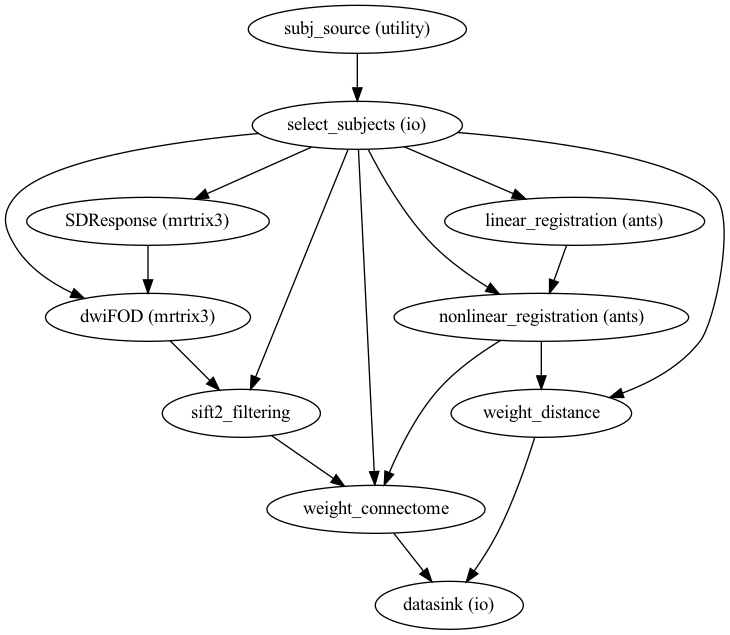

In [ ]:
#example
from IPython.display import Image

post_wf.create_nodes()
post_wf.connect_nodes(wf_name='connectomes')
post_wf.draw_pipeline(graph_type='flat')
Image('./testing/BIDS_dir/derivatives/pipetography/graph/postprocessing.png')

In [ ]:
#example
post_wf.run_pipeline(parallel=2)

View outputs:

In [ ]:
!tree ./testing/BIDS_dir/derivatives/pipetography

In [ ]:
#usage
#example
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load matrices:
CM = pd.read_csv('./testing/BIDS_dir/derivatives/pipetography/sub-01/ses-002/connectomes/BN_Atlas_246_1mm/connectome.csv', header = None)
DM = pd.read_csv('./testing/BIDS_dir/derivatives/pipetography/sub-01/ses-002/connectomes/BN_Atlas_246_1mm/distances.csv', header = None)

# Visualize:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = (12,12))
# log1p - calculates log(1+x)
cdk=ax1.imshow(np.log1p(CM), cmap = plt.get_cmap('inferno'), interpolation = 'nearest')
ax1.set_title('BNA246 Connectivity Matrix')
cbar=fig.colorbar(cdk, ax=ax1, shrink=0.4)
cbar.set_label('Log Scale Streamline Counts')

ddk=ax2.imshow(DM, interpolation = 'nearest')
ax2.set_title('BNA246 Distance Adjacency Matrix')
dbar=fig.colorbar(ddk, ax=ax2, shrink=0.4)
dbar.set_label('Mean Streamline Length (mm)')